# EDA and Visualizations
I used this notebook to go through some basic EDA and make a few graphs with (almost) no modeling. First, I will take care of the necessary packages.

In [1]:
# Import the packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
df = pd.read_csv('../data/travel_tidy.csv').drop_duplicates(subset='event_id')

# Set a plot theme for seaborn
sns.set_theme(style='ticks', rc={"axes.spines.right": False, "axes.spines.top": False, "figure.dpi":300, 'savefig.dpi':300}, font='Arial')

### Number of trips by name
Now I will separate the dataset into secretaries and presidents and will plot the number of trips (row counts) by name of an official. I will also calculate the mean number of trips for both visit types. There are a lot of zeros in the daataset, the the mean might not be the most representative metric for the most common number of trips per president (could be an ide for future analyses).

39.75
99.65625


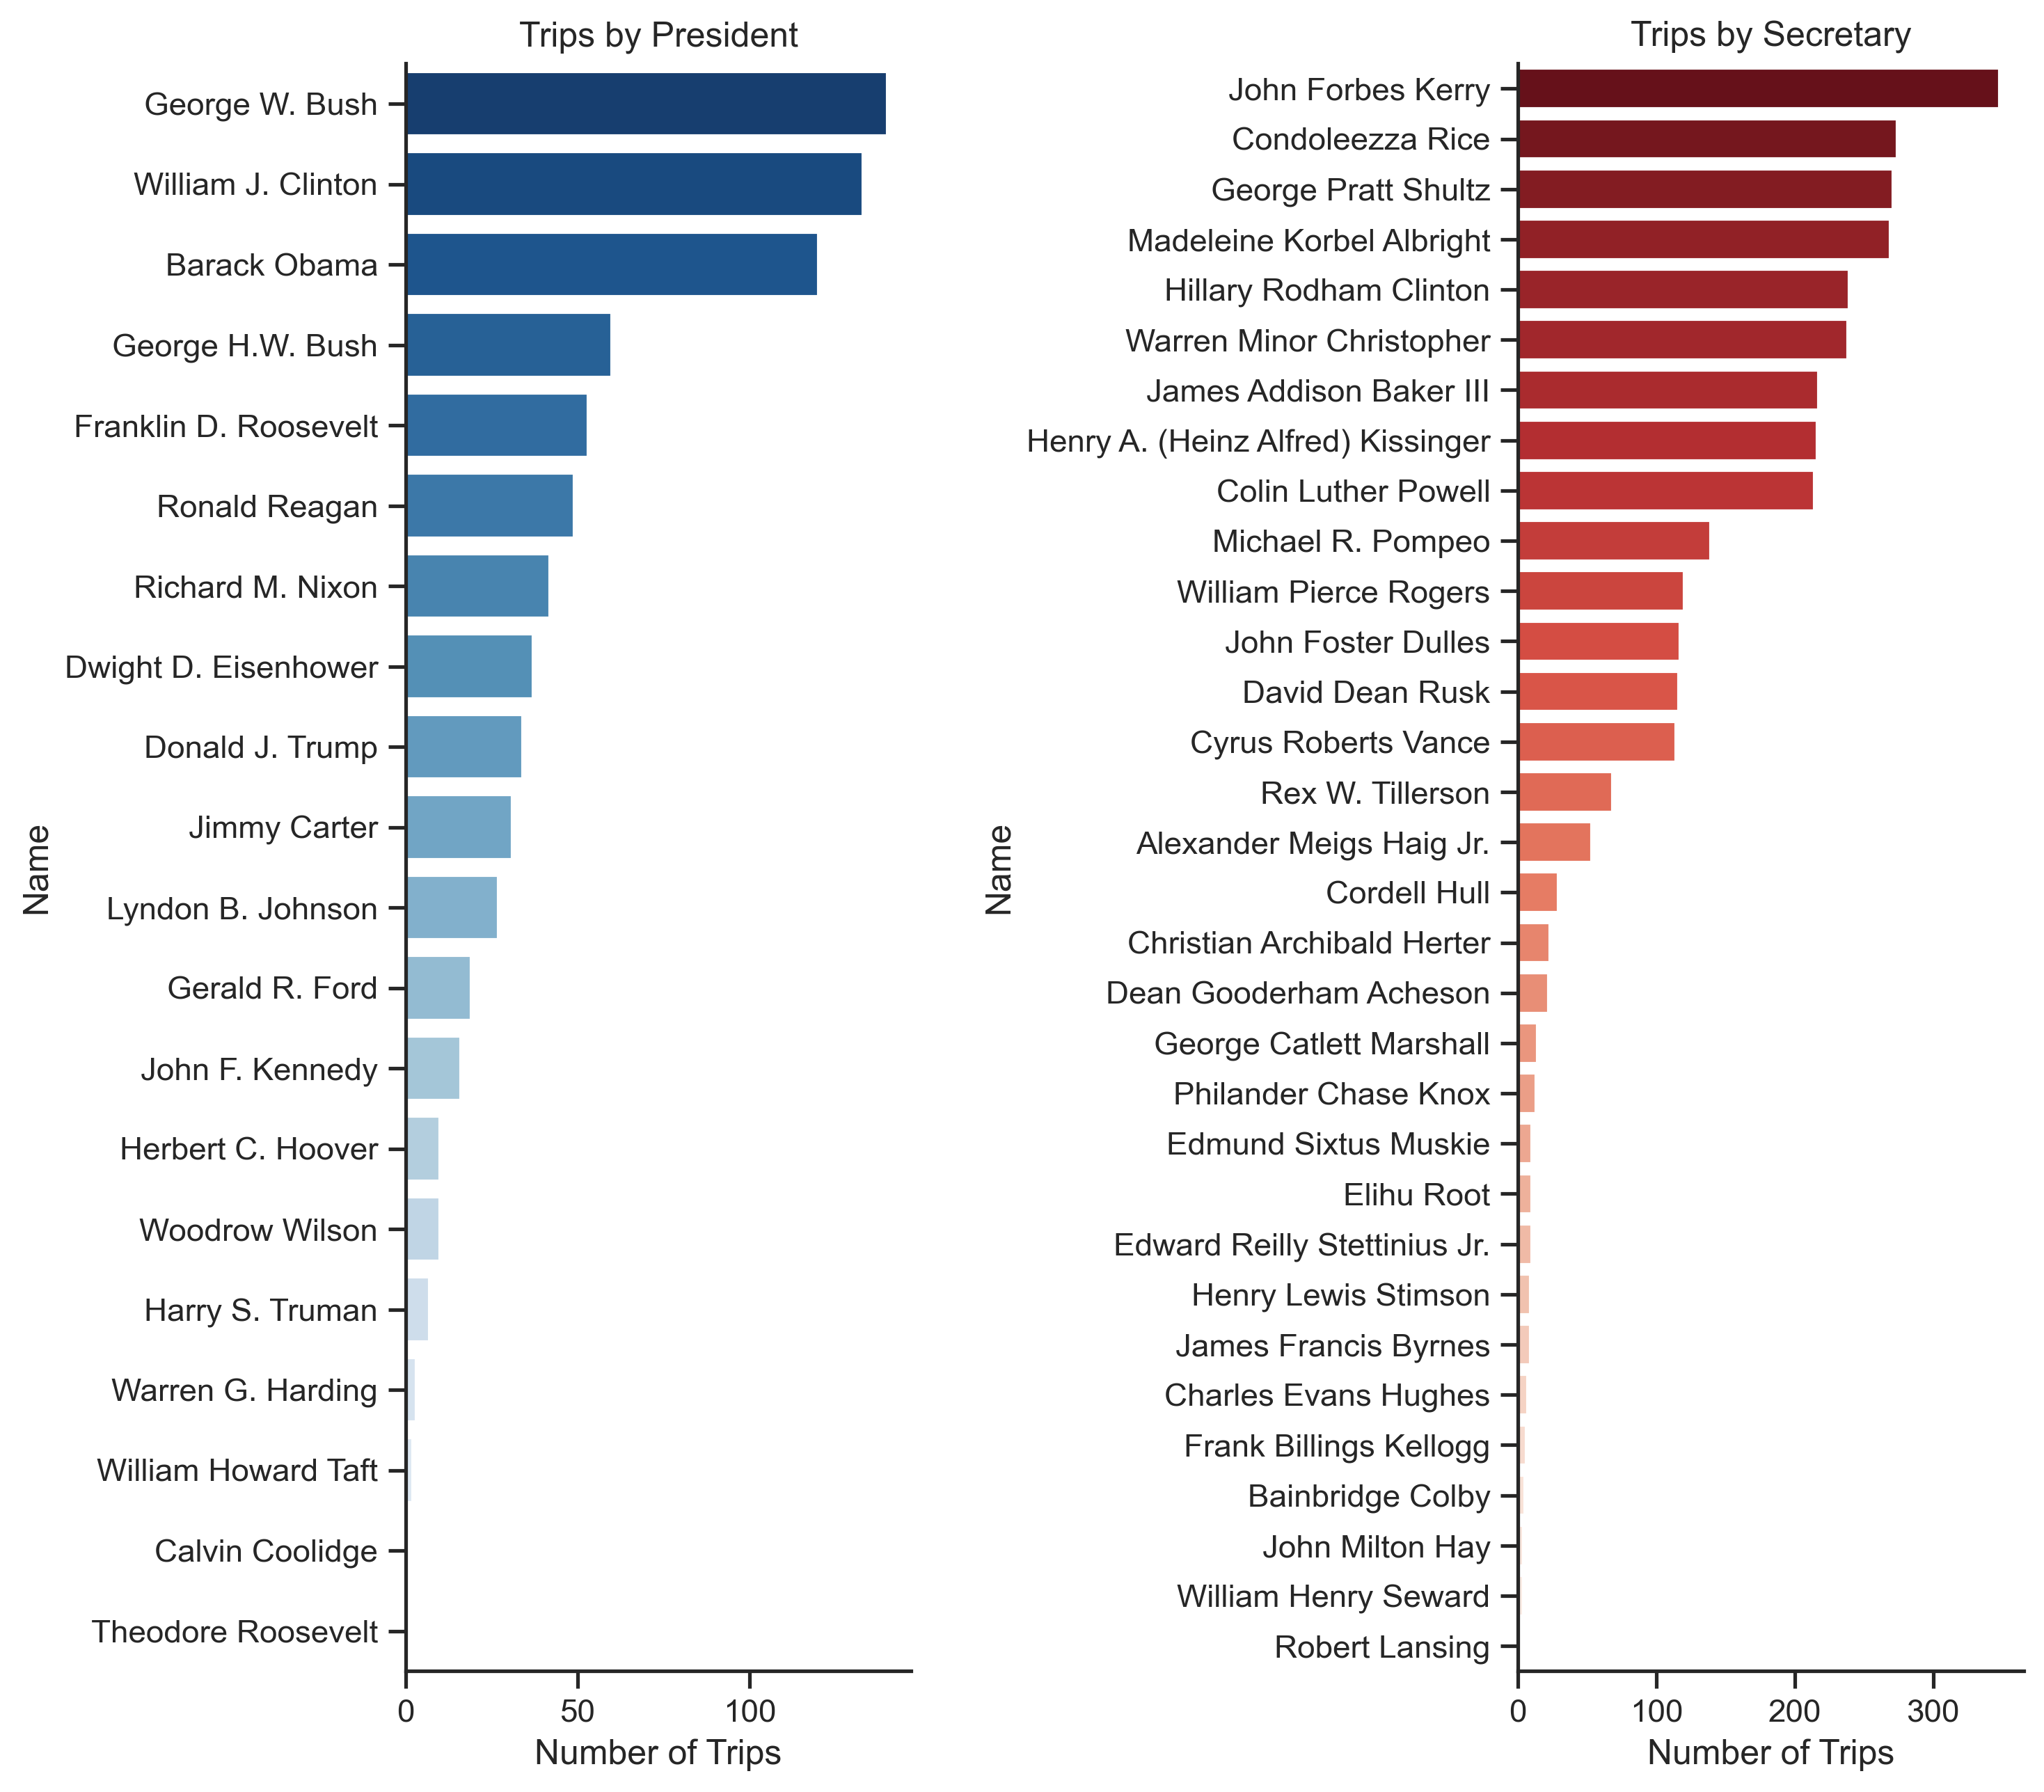

In [2]:
# Separate the dataset
counts_pres = df[df['visit_type'] == 'president'].value_counts(subset='name')
counts_sec = df[df['visit_type'] == 'secretary'].value_counts(subset='name')

# Plot the bars
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)
fig.subplots_adjust(wspace=1.2)
sns.barplot(x=counts_pres.values, y=counts_pres.index, palette='Blues_r', ax=ax[0])
sns.barplot(x=counts_sec.values, y=counts_sec.index, palette='Reds_r', ax=ax[1])

# Set the labels for the subplots
ax[0].set_title('Trips by President')
ax[0].set_xlabel('Number of Trips')
ax[0].set_ylabel('Name')
ax[1].set_title('Trips by Secretary')
ax[1].set_xlabel('Number of Trips')
ax[1].set_ylabel('Name')

# Calculate the mean number of visits per president
print(counts_pres.values.mean())
print(counts_sec.values.mean())

### Number of trips by country
Here I will do the same thing by I will plot the trips by the country of destination. I will also calculate means for both visit types just like before.

13.680851063829786
54.44186046511628


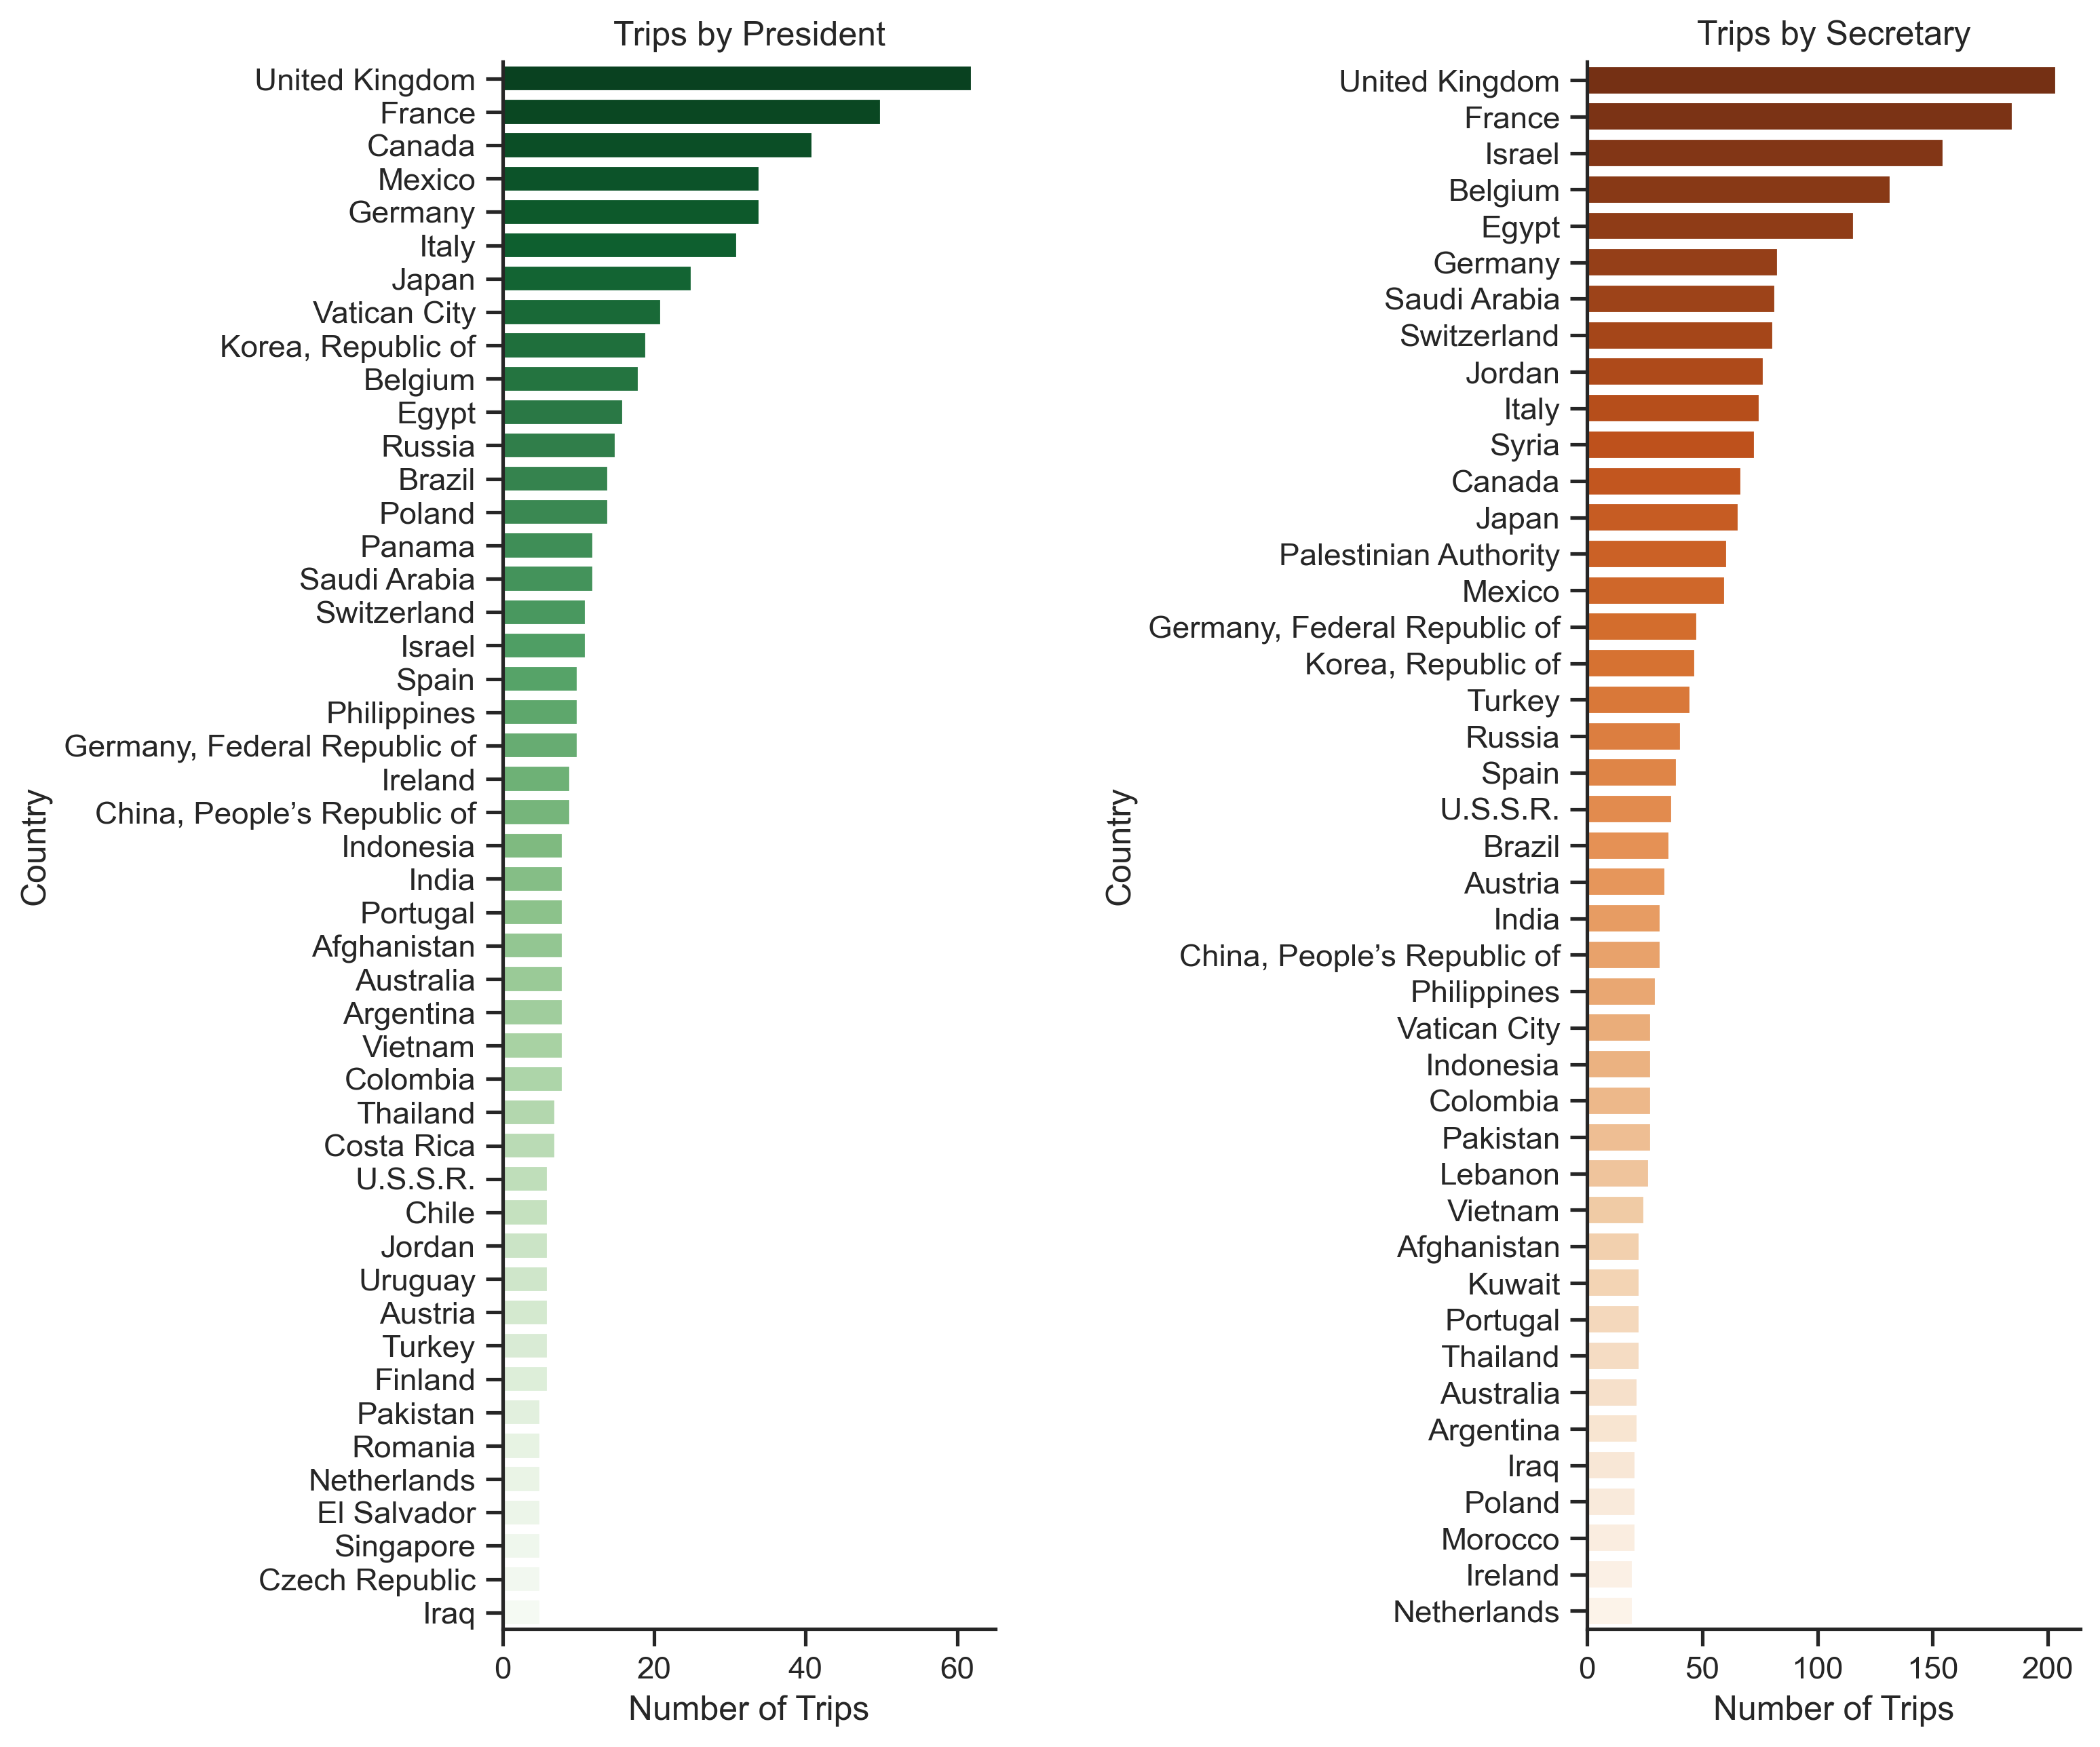

In [3]:
# Separate the dataset
counts_pres = df[df['visit_type'] == 'president'].value_counts(subset='country').loc[lambda x : x >= 5]
counts_sec = df[df['visit_type'] == 'secretary'].value_counts(subset='country').loc[lambda x : x >= 20]

# Plot the bars
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)
fig.subplots_adjust(wspace=1.2)
sns.barplot(x=counts_pres.values, y=counts_pres.index, palette='Greens_r', ax=ax[0])
sns.barplot(x=counts_sec.values, y=counts_sec.index, palette='Oranges_r', ax=ax[1])

# Set the labels for the subplots
ax[0].set_title('Trips by President')
ax[0].set_xlabel('Number of Trips')
ax[0].set_ylabel('Country')
ax[1].set_title('Trips by Secretary')
ax[1].set_xlabel('Number of Trips')
ax[1].set_ylabel('Country')

# Calculate the mean number of visits per country
print(counts_pres.values.mean())
print(counts_sec.values.mean())

### Change in trip numbers over time
I really wanted to take the date component of the dataset and work with it for a little, but this required some transformations and feature creation. So first I would like to convert ISO dates into a Python date, then get the delta between the end date and the start date to get the length of the trip. I will also get a year separately to properly plot and summarize the data frame.

In [4]:
# Convert the strings to date objects
df['date_start'] = df['date_start'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df['date_end'] = df['date_end'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

# Calculate the difference and get only the day count
df['time_delta'] = df['date_end'] - df['date_start']
df['time_delta'] = df['time_delta'].apply(lambda x : int(str(x)[0]))

# Get the year separately
df['year'] = df['date_start'].apply(lambda x : str(x.strftime('%Y')))
df

,event_id,visit_type,name,country,locale,remarks,date_start,date_end,time_delta,year
0,0,president,Theodore Roosevelt,Panama,Colon,To inspect construction of Panama Canal. First...,1906-11-14,1906-11-17,3,1906
2,1,president,William Howard Taft,Panama,Colon,Inspected construction of Panama Canal. Met wi...,1909-01-29,1909-02-07,9,1909
4,2,president,William Howard Taft,Mexico,Ciudad Juarez,Part of an exchange of visits with President D...,1909-10-16,1909-10-16,0,1909
5,3,president,Woodrow Wilson,United Kingdom,Bermuda,Vacation. [Visit made as President-elect.],1912-11-18,1912-12-13,2,1912
6,4,president,Woodrow Wilson,France,Paris,Attended Preliminary to the Paris Peace Confer...,1918-12-14,1918-12-25,1,1918
...,...,...,...,...,...,...,...,...,...,...
4669,3979,secretary,Michael R. Pompeo,Georgia,Tbilisi,"Met with President Zourabichvili, Prime Minist...",2020-11-17,2020-11-18,1,2020
4670,3980,secretary,Michael R. Pompeo,Israel,Jerusalem,Met with Prime Minister Benjamin Netanyahu and...,2020-11-18,2020-11-19,1,2020
4671,3981,secretary,Michael R. Pompeo,United Arab Emirates,Abu Dhabi,Met with Abu Dhabi Crown Prince Mohammed bin Z...,2020-11-21,2020-11-21,0,2020
4672,3982,secretary,Michael R. Pompeo,Qatar,Doha,Met with Amir Tamim bin Hamad Al Thani and Dep...,2020-11-21,2020-11-21,0,2020


Okay, so here comes the messy part. Pandas groupby() in conjunction with mean() changes the dtype of the object from data frame to series and starts treating the feature used for grouping as the index (primary key) of the dataset. This is not good and actually causes variable name clashes when trying to convert back to data frame, so a big portion of this chunk is a back-and-forth to get the summarized series back to proper data frame.

I wanted to include the proportion of trips accounted for by either president or secretary, but since I dropped year duplicates, I needed to recalculate the normalized counts (proportions) relative to secretary if the year dropped was 'secretary'. Then, I converted years to integers for proper plotting and joined the data frames.

Finally, plotting. Seaborn has a very neat lmplot() function that builds a scatter and a linear regression line for you, but I wanted to color my points by proportion of secretary visits, so when you put <code>hue='visit_prop'</code> it actually builds a regression line for each category. For me it was even worse because it treated the proportion as a discrete variable, so I had each number as its own category.

The solution was pretty easy (though I spent a lot of time trying to troubleshoot it) - just hide the scatter in regplot() and plot it separately with the hue variable you want.

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Average Time per Trip (days)'),
 Text(0.5, 1.0, 'Average Days per Trip by Year')]

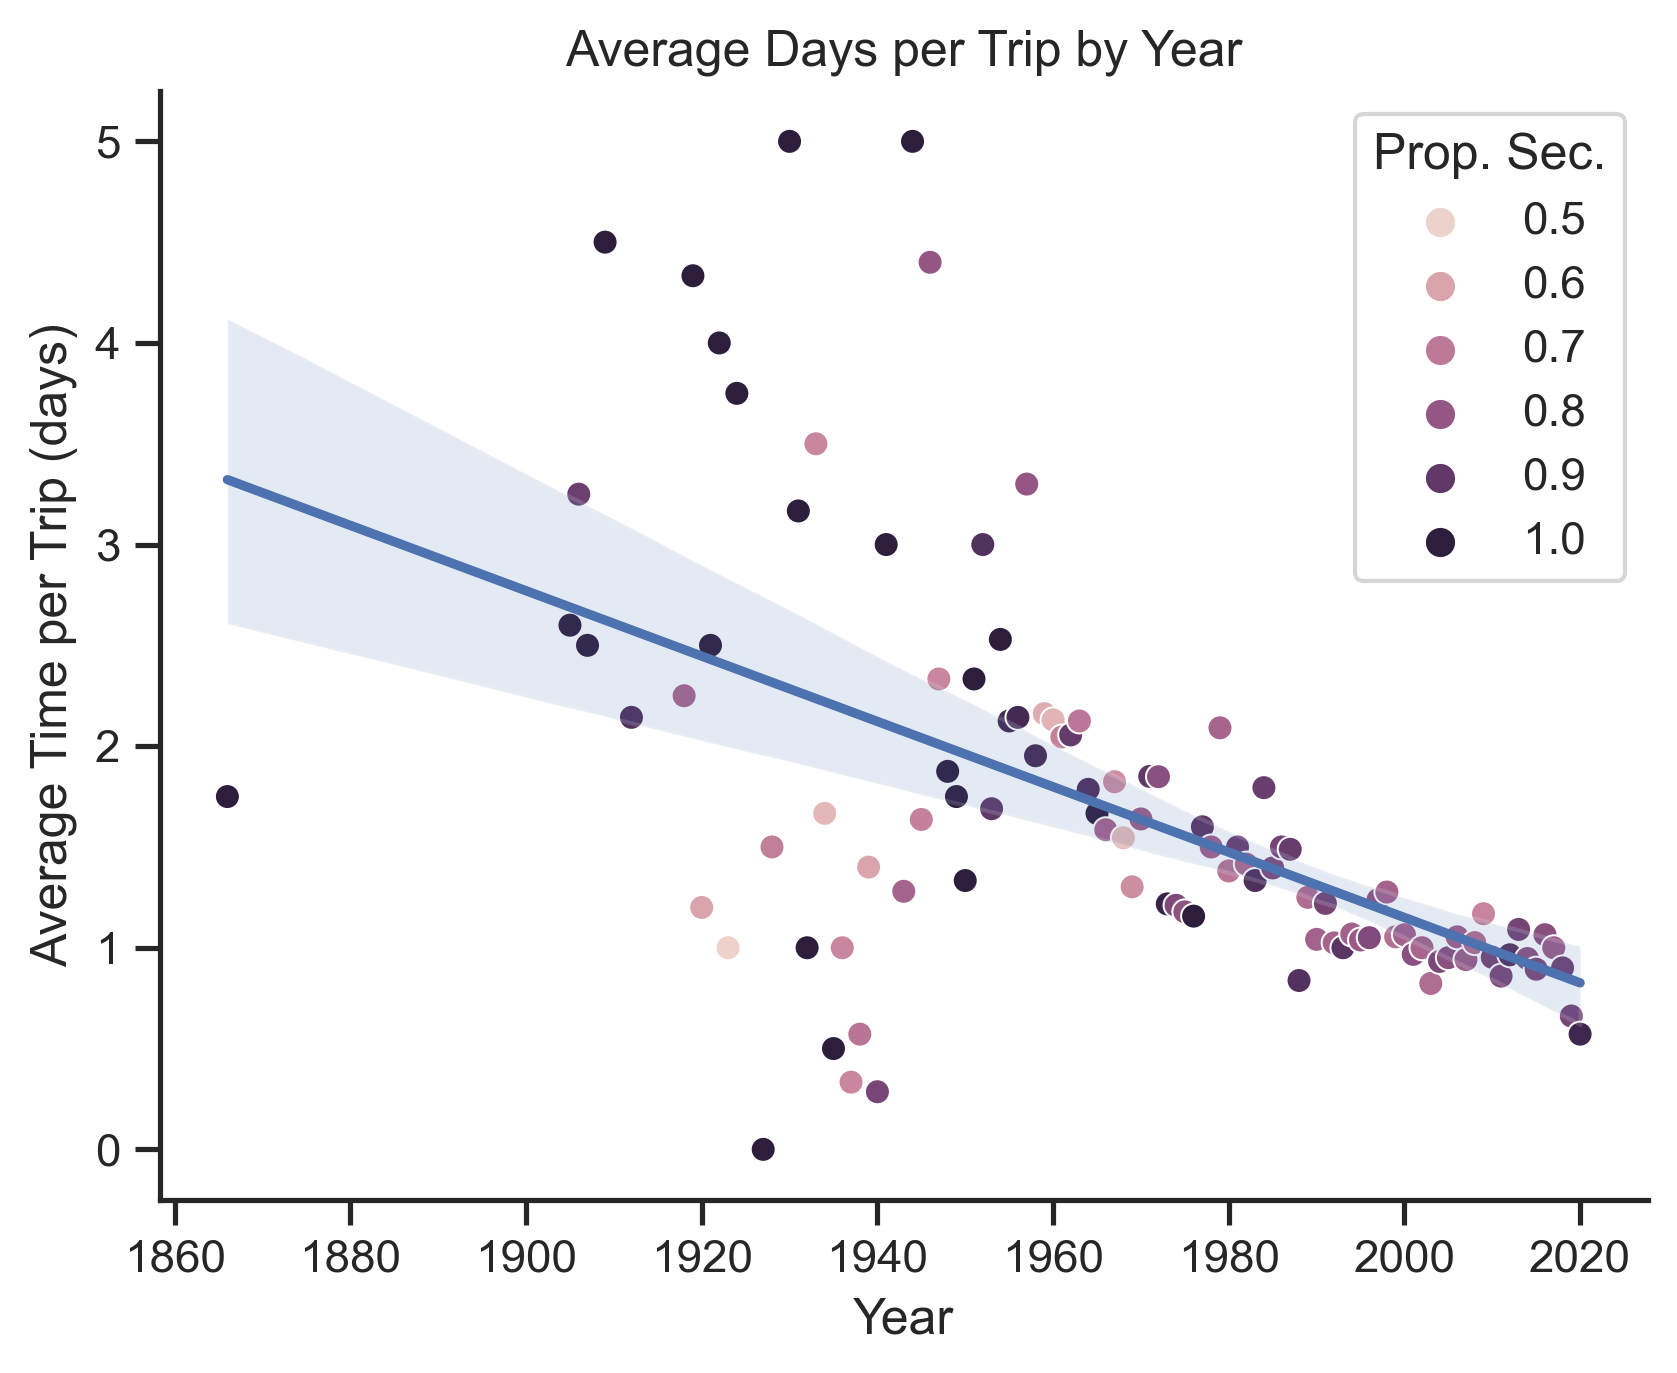

In [5]:
# Get the mean length of trip for each year
avglen_by_year = df.groupby(['year'])['time_delta'].mean().to_frame().reset_index()

# Get trip counts for each visit type and normalize to get proportions
prop_pres_by_year = (df.groupby(['year']).visit_type
                       .value_counts(normalize=True)
                       .to_frame()
                       .rename(columns={'visit_type' : 'visit_prop'})
                       .reset_index())

prop_pres_by_year = prop_pres_by_year.drop_duplicates('year')

# Recalculate proportions for non-secretary rows
for i, row in prop_pres_by_year.iterrows():
    if row['visit_type'] == 'president':
        row['visit_prop'] = 1 - row['visit_prop']

# Convert yers to integers and join the datasets
avglen_by_year['year'] = avglen_by_year['year'].astype(int)
prop_pres_by_year['year'] = prop_pres_by_year['year'].astype(int)
avglen_by_year = avglen_by_year.merge(prop_pres_by_year)

# Plot the scatter + the regression line
fig, ax = plt.subplots()
sns.scatterplot(data=avglen_by_year, x='year', y='time_delta', hue='visit_prop', ax=ax).legend(title='Prop. Sec.')
sns.regplot(data=avglen_by_year, x="year", y="time_delta", scatter=False, ax=ax).set(xlabel='Year', ylabel='Average Time per Trip (days)', title='Average Days per Trip by Year')